Ocenjevanje in tehnike izbora značilk
===

In [1]:
import Orange
import numpy as np
import matplotlib.pyplot as plt
import bisect
from scipy import stats
from operator import itemgetter
from Orange.preprocess.preprocess import Preprocess
%matplotlib inline

Podatki
---
V tem zapisu raziskujemo, ali ima kajenje sploh kakšne posledice. Recimo, na [limfocite](https://sl.wikipedia.org/wiki/Limfocit), to je na vrsto belih krvnih telesc. Še najbolj sistematično bomo posledice opazovali tako, da pogledamo, kaj se dogaja v celicah limfocitov, in to tako, da opazujemo, ali je pri celicah kadilcev kakšna razlika med izražanjem vseh genov, torej med tem, koliko so geni aktivni pri proizvajanju proteinov (še bolj direktno bi bilo, da bi zmerili, koliko je posameznih proteinov v celicah, a je ta tehnologija dražja in manj dostopna). Ok, tule nas je morda malce zaneslo pri domeni, ampak na koncu bo enostavno. Imamo primere (ženske kadilke ali nekadilke) in meritve izražanj genov v njihovih limfocitih (atributi). Uporabimo podatke, ki so prosto na voljo na spletu v bazi [GEO](https://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS3713). Da bo zadeva potekala hitreje, spodaj delamo na podatkih, kjer smo naključno izbrali 1000 značilk.

In [2]:
file_name = "data/smoking-large.tab"
# file_name = "data/smoking-small.tab"
data = Orange.data.Table(file_name)
print("Instances: %d, Features: %d" % (len(data), len(data.domain.attributes)))
data.domain.class_var.values

Instances: 79, Features: 14093


['cigarette smoke', 'control']

In [3]:
X0 = data.X[data.Y==0]
X1 = data.X[data.Y==1];

Vizualizirajmo, kako so porazdeljene vrednosti izbranega atributa pri posameznem razredu (še boljši od razsevnega diagrama, ki ga tu prikazujemu, bi bil kakšen hitrogram vrednosti).

In [4]:
X1.shape

(40, 14093)

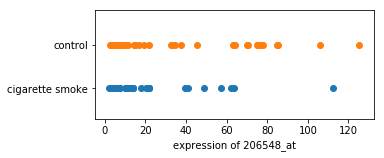

In [5]:
def plot_class_points(att_id):
    plt.figure(figsize=(5, 2))
    plt.scatter(X0[:, att_id], np.ones(X0.shape[0]))
    plt.scatter(X1[:, att_id], np.ones(X1.shape[0])*2)
    plt.yticks([1, 2], data.domain.class_var.values)
    plt.ylim(0.3, 2.8);
    plt.xlabel("expression of %s" % data.domain.attributes[att_id].name)

plot_class_points(3)

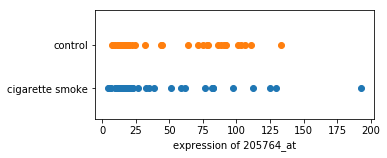

In [6]:
plot_class_points(2)

Zanima nas, ali obstajajo značilke, katerih vrednosti pri posameznem razredu so različne. Zgoraj vidimo, da prva značilka (indeks značilke 0) malce bolje loči med razredoma kot tretja značilka (indeks 2).

Ocenjevanje informativnosti značilk
--
Zgornjo intuicijo o tem, katera značilka bolje ločuje med razredi, je moč kvantificirati. Uporabimo [Studentovo t-statistiko](https://en.wikipedia.org/wiki/Paired_difference_test) za ocenjevanje razlik med dvema skupinama meritev $X_1$ in $X_2$. Želimo, da bi bila povprečna vrednost med tema skupinama čim bolj drugačna, torej absolutna razlika med njima čim večja, ter da bi razsipanje vrednosti znotraj skupin bilo čim manjše. Pri slednjem bi bilo dobro upoštevati tudi število primerov v posamezni skupine. Vse skupaj strnemo v enačbo za t-statistiko:

$$t=\frac{\bar{X_1}-\bar{X_2}}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$$

kjer sta $s_1$ in $s_2$ standardna odklona vzorcev $X_1$ in $X_2$. Zanima nas povprečna vrednost t-statistike, torej $|t|$. Za njen izračun uporabimo funkcijo iz paketa scipy. 

In [7]:
scores = np.abs(stats.ttest_ind(X0, X1, axis=0))[0]
scores[:5]

array([ 1.79696383,  0.6598319 ,  0.51208726,  2.28699144,  0.29968853])

Ocenjene vrednosti dobro podpirajo našo ugotovitev, da prvi atribut bolje loči od tretjega. Zanima pa nas, kakšna je porazdelitev atributnih ocen.

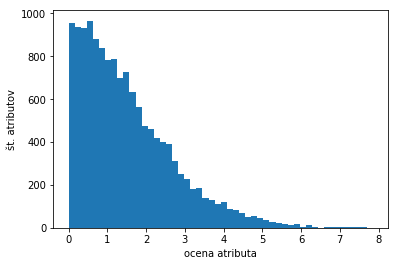

In [8]:
plt.hist(scores, 50)
plt.ylabel("št. atributov")
plt.xlabel("ocena atributa");

Katera značilka najbolje loči naša razreda?

In [9]:
ind_score = sorted(enumerate(scores), key=itemgetter(1), reverse=True)
ind_score[:3]

[(7794, 7.8535032182462308),
 (8050, 7.6887508659502251),
 (7232, 7.5466419572662868)]

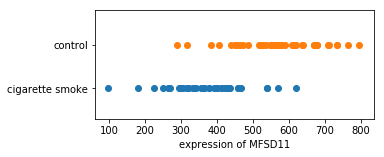

In [10]:
plot_class_points(ind_score[0][0])

Permutacijski test
--
Naši podatki vsebujejo veliko število atributov in relativno majhno število primerov. Prav lahko bi se zgodilo, da je kakšen od teh atributov informativen popolnoma naključno, torej, da so meritve bile slučajno take, da so ravno ločile izbrani dve skupini. Kakšna bi bila potem porazdelitev atributnih ocen, torej porezdelitev pri naključnih meritvah? Do naključnih meritev lahko pridemo tako, da vrednosti za dani atribut premešamo, še lažje pa to storimo za vse atribute naenkrat tako, da premešamo vrednosti razredne spremenljivke. Po tej permutaciji ocenimo značilke. Da vse skupaj ne bo odvisno od ene same permutacije razredov, postopek nekajkrat ponovimo.

In [11]:
np.random.seed(42)

def scores_by_class_permutation(data, k=5):
    y = np.copy(data.Y)
    X = data.X
    scores_null = np.array([])
    for i in range(k):
        np.random.shuffle(y)
        scores_null = np.hstack((
            scores_null,
            np.abs(stats.ttest_ind(X[y == 0], X[y == 1], axis=0)[0])
        ))
    return scores_null

null = scores_by_class_permutation(data)

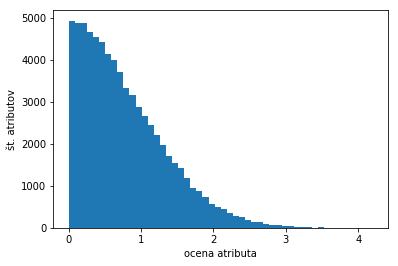

In [12]:
plt.hist(null, 50)
plt.ylabel("št. atributov")
plt.xlabel("ocena atributa");

Porazdelitev z naključnimi podatki je dosti ožja od te z realnimi podatki.

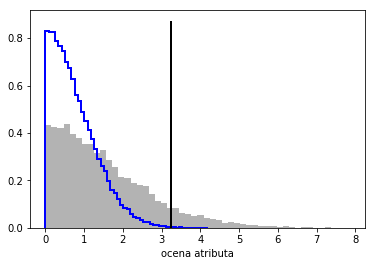

In [13]:
plt.hist(scores, 50, color="0.7", normed=True)
plt.hist(null, 50, color="blue", normed=True, histtype='step', lw=2)
p = 0.001

threshold = np.sort(null)[int((1-p)*len(null))]
plt.vlines(threshold, plt.ylim()[0], plt.ylim()[1], lw=2, color="k")
plt.xlabel("ocena atributa")
plt.savefig("tmp.pdf");

Zgoraj smo namenoma postavili mejo (črna vertikalna črta) tako, da je desno od meje samo zelo majhen delež ocen, ki so bile pridobljene na naključnih podatkih (porazdelitev označena z modro črto). Za vse atribute, ki so bili ocenjeni desno od te meje, lahko trdimo, da je vrednost njihove ocene taka, da bi jo težko dobili na naključnih podatkih. Verjetnost, da bi se to zgodilo, je enaka vrednosti $p$, na podlagi katere smo mejo določili. Če bi radi to verjetnost še zmanjšali, ustrezno zmanjšamo vrednost $p$. Koliko je sploh takih atributov?

In [14]:
np.sum(scores > threshold)

1327

V podatkih je torej samo desetina atributov, za katere kaže, da so povezani z razredom. To je pravzaprav za naš problem zelo veliko. Spomnimo se, preučujemo učinke kajenja in kot vse kaže obstaja kar ena desetina vseh opazovanih genov, katerih izražanje v limfocitih se zaradi kajenja spremeni.

Izbor značilk
---
Zgoraj smo ravno pridelali metodo za ocenjevanje in izbor značilk po principu filtriranja. Ocenjevanje nam pomaga pri razpoznavi tistih značilk, ki so za naš problem pomembne. Če bi bili biologi, bi nas seznam genov, ki so najbolj različno izraženi pri dveh skupinah (kadilke, nekadilke) močno zanimali. A nismo, tako da bomo to zaenkrat preskočili (se boste pa s tem pozabavili pri domači nalogi na problemu, kjer bo informativnost značilk moč enostavno interpretirati). Tu razmislimo o drugačni uporabi filtriranja značilk. In sicer, v povezavi z napovednimi modeli. Ideja je, da lahko dober izbor značilk pomaga h gradnji bolj točnih modelov, ali pa vsaj pomaga k poenostavitvi problema tako, da so lahko ti odvisni od manj parametrov in jih je zato hitreje naučiti in se morda lahko manj prilegajo k učnim podatkom.

Za poskus, ali zgornje drži, zgradimo razred za predprocesiranje podatkov, ki iz podatkov izloči $k$ najbolje informativnih atributov in vrne podatke, ki te vsebujejo.

In [15]:
class SelectBestFeatures(Preprocess):
    def __init__(self,
                 k=10,
                 measure=lambda X, y: np.abs(stats.ttest_ind(X[y == 0], X[y == 1], axis=0)[0])
                 ):
        self.k = k
        self.measure = measure

    def __call__(self, data):
        scores = self.measure(data.X, data.Y)
        ind = set(list(zip(*sorted(zip(scores, range(len(
            data.domain.attributes))), reverse=True)[:self.k]))[1])
        att = [a for i, a in enumerate(data.domain.attributes) if i in ind]
        domain = Orange.data.Domain(att, data.domain.class_vars)
        new = data.from_table(domain, data)
        print("selecting x ", len(new.domain.attributes))
        return new

In [16]:
fss = SelectBestFeatures(k=10)
selected = fss(data)
len(selected.domain.attributes)

selecting x  10


10

In [17]:
data = Orange.data.Table(file_name)
lr = Orange.classification.LogisticRegressionLearner()
knn = Orange.classification.KNNLearner()
res = Orange.evaluation.CrossValidation(data, [lr, knn], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

array([ 0.92405063,  0.72151899])

In [18]:
np.random.seed(42)
res = Orange.evaluation.CrossValidation(selected, [lr, knn], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

array([ 0.78481013,  0.88607595])

Ni slabo. Z veliko manj atributi dosegamo podobno točnosti pri logistični regresiji in k-najbližjih sosedov.

In [19]:
fss = SelectBestFeatures(k=20)
selected_20 = fss(data)

selecting x  20


In [20]:
np.random.seed(42)
res = Orange.evaluation.CrossValidation(selected_20, [lr, knn], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

array([ 0.92405063,  0.92405063])

Točnost logistični regresiji malce pade, k-najbližjim sosedom pa še naraste. Razlog za razliko med rezultati obeh metod je v tem, kako obravnavata značilke. Logistična regresija sama najde ustrezne uteži značilk, dočim je teža značilk pri k-najboližjih sosedih enaka, saj je ta metoda odvisna od mere za razdaljo med primeri in večina mer (tudi privzeta, ki je evklidska razdalja) med značilkami ne ločuje oziroma jih ne uteži.

Pa je naš pristop res pravi? Naredimo (en malce odštekan) eksperiment. Uničimo podatke, izberimo nekaj najboljših značilk in poženimo prečno preverjanje. Podatke bomo "uničili" tako, kot smo to naredili pri permutacijskem testu: premešali bomo vrednosti razredne spremenljivke.

In [21]:
y = np.copy(data.Y)
np.random.shuffle(y)
destroyed = Orange.data.Table(data.X, y)

In [22]:
res = Orange.evaluation.CrossValidation(destroyed, [lr, knn], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

array([ 0.46835443,  0.44303797])

In [23]:
fss = SelectBestFeatures(k=10)
selected_10 = fss(destroyed)
res = Orange.evaluation.CrossValidation(selected_10, [lr, knn], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

selecting x  10


array([ 0.83544304,  0.79746835])

Huh! Naša taktika izbora se obnese celo na čisto zanič podatkih. Hm. Pa je to res tisto, kar smo želeli? Seveda ne. Na naključnih podatkih bi morala točnost napovedi biti mizerna (bralec: kakšna točno?). Tako pa je skoraj odlična. Le zakaj? Kaj smo storili z izborom destih najboljših atributov na naključnih podatkih? Čemu pravzaprav služi prečno preverjanje po opravljenem izboru?

Prečno preverjanje nam tu pokaže le, da smo med številnimi atributi izbrali tiste, ki so, čeprav po naklučju, dobro povezani z razredom. Seveda med razredom obstaja, saj smo ravno take atribute izbrali. In pri tem upoštevali vrednost razreda. V naslednjem koraku pa smo se delali, torej pri prečnem preverjanju, da poznamo samo del primerov (učna množica), drugega dela pa ne (testna množica). A ta del smo že videli. Kje? Pri predhodnem izboru atributov, seveda. Taktika predhodnega izbora atributov, ki ji sledi prečno preverjanje, je goljufija.

Izbor značilk kot predprocesiranje pri učenju
---
Tale naslov je pravzaprav čuden. Kaj nismo to ravnokar počeli in pokazali, kako napačen je postopek. Da, ampak smo predprocesiranje vključili na napačnem koncu. Predprocesiranje podatkov je namreč korak, ki je del učenja, in ga moramo torej poganjati znotraj prečnega preverjanja. Torej, prečno moramo preveriti celoten postopek, tako ocenjevanje atributov, izbor le teh, in potem gradnjo modelov. Vse to lahko torej počnemo le na učni množici, testiramo pa na popolnoma ločeni množici, ki je pri ocenjevanju in izboru atributov nismo upoštevali.

In [24]:
lr = Orange.classification.LogisticRegressionLearner()
fss = SelectBestFeatures(k=20)
knn_fss = Orange.classification.KNNLearner()
knn_fss.preprocessors = knn_fss.preprocessors + [fss]
knn = Orange.classification.KNNLearner()

In [25]:
res = Orange.evaluation.CrossValidation(data, [knn, knn_fss], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

selecting x  20
selecting x  20
selecting x  20
selecting x  20
selecting x  20


array([ 0.72151899,  0.83544304])

Tole je bil test, ali dela dobro: za k-najbližjih sosedov predprocesiranje fino pomaga. Spomnimo se: tokrat smo predprocesirali podatke samo na učni množici. Sledi še poskus z pravo uporabo predprocesiranja, a na "uničenem" naboru podatkov.

In [26]:
res = Orange.evaluation.CrossValidation(destroyed, [knn_fss], k=5, random_state=42)
Orange.evaluation.scoring.CA(res)

selecting x  20
selecting x  20
selecting x  20
selecting x  20
selecting x  20


array([ 0.4556962])

Dobro, fino, ne dela. Tako kot smo pričakovali in kot mora biti. Tokrat nismo goljufali in dobili pravo oceno točnosti.

Nekratkovidno ocenjevanje atributov
---
Tu bomo ustvarili en težek nabor podatkov. Težek zato, ker na njem pade velika večin učnih algoritmov. Oziroma, morda skoraj vsi. Oziroma, vsi moderni učni algoritmi (morda pa se motim, ampak resno ne poznam algoritma, ki bi bil spodnjim podatkom kos). Oziroma, skoraj vedno odpovejo. Bomo videli, kje in zakaj.

Podatki pa so:

In [27]:
def create_tricky(n=300, m=10):
    """Create data set with n instances and m features."""
    np.random.seed(42)
    X = np.random.rand(n, m)
    y = (X[:, 0] > 0.5) == (X[:, 1] > 0.5)
    return Orange.data.Table(X, y)

tricky_data = create_tricky(300, 10)

Izgleda sicer silno enostavno. Razred je binaren, odvisen samo od dveh atributov in ima vrednost 1 ko imata ta vrednost nad 0.5, in 0 sicer. Problem pa dejansko je, da brez vedenja ***obeh*** atributov ne moramo vedeti, kakšen bo razred. Mere, kot smo jo vpeljali zgoraj (spomnimo se, t-statistika), pri tem problemu popolnoma odpovejo, saj ocenjujejo po en sam atribut v odsotnosti vseh ostalih.

In [28]:
maj = Orange.classification.MajorityLearner()
rf = Orange.classification.RandomForestLearner(n_estimators=200)
res = Orange.evaluation.CrossValidation(tricky_data, [maj, lr, rf], k=10, random_state=42)
Orange.evaluation.scoring.CA(res)

array([ 0.52333333,  0.50333333,  0.85333333])

Logistična regresija zgreši popolnoma. Njena točnost je nekje tam, kjer je model, ki vedno napoveduje večinski razred učne množice. Se pa presenetljivo dobro obnašajo na tem primeru naključni gozdovi. Ti delujejo po principu "slepa kura zrno najde", saj v zgornjem vozlišču pri vsakokratni gradnji le po naklučju zberejo ali prvi ali drugi atribut. Pri desetih atributih je verjetnost za to 20%. Ko je v zgornjem vozlišču izbran eden od teh dveh atributov, bo drevo pravo in bo v naslednjem vozlišču zbran komplementarni atribut. Model bom v tem primeru popoln. Varianta je tudi, da do takega izbora pride v nekorenskih vozliščih, kar bi vodilo do manj popolnih modelov. Ni pa izbor "pravega" atributa tu načrten.

Naključni gozd lahko uporabimo za ocenjevanje atributov. Načinov za to je več. Izumitelj Leo Brieman je na primer predlagal, da v te namene zgradimo gozd na bootsrap vzorcu podatkov, ter ga vrednotimo na preostalih podatkih, torej teh, ki niso zajeti v vzorcu (t.im. vzorec *out-of-bag*). Za izdelani model napovedno vrednost atributo ocenimo tako, da v out-of-bag vrednosti tega atributa premešamo (tako, kot smo to počeli pri permutacijskem testu). Atributi, pri katerih bo na ta način točnost na testni množici padla, so bolj pomembni. Drug, hitrejši način pa je, da pregledamo drevesa v gozdovih in preštejemo, kolikokrat je posamezni atribut v drevesu uporaben in kje, pri čemer damo višjo težo uporabi bližje korenu drevesa. Ta način ocenjevanja atributov je odvisen samo od modela in ne potrebuje ločene testne množice.

Spodaj nas zanima, kako dobre so take ocene. Prvi in drugi atribut, iz katerih smo izračunali vrednost razreda, bi morala biti najbolje ocenjena in biti na prvem mestu.

In [29]:
def position(indices, scores):
    """Positions of scores with index in indices in sorted list of scores"""
    s = sorted(scores)
    n = len(scores)
    return [bisect.bisect(s, scores[i]) for i in indices]

def score_positions(positions, n):
    np = len(positions)
    return [1-(n-p-i)/(n-np) for i, p in enumerate(positions)]

def score_scores(indices, scores):
    positions = position(indices, scores)
    positions.sort(reverse=True)
    return score_positions(positions, len(scores))

In [30]:
# sanity check here
scores = [10, 20, 3, 5, 2, 30]
positions = position([0,1], scores)
positions.sort(reverse=True)
print(positions, len(scores))
score_positions(positions, len(scores))

[5, 4] 6


[0.75, 0.75]

In [31]:
forest = rf(tricky_data)
relief = Orange.preprocess.score.ReliefF()
scores = relief(tricky_data)
ind = [0, 1]
score_scores(ind, scores), score_scores(ind, forest.skl_model.feature_importances_)

([1.0, 1.0], [1.0, 1.0])

Super, dela. Po oceni iz naključnega gozda sta naša informativna atributa najbolje ocenjena. Ocene smo izračunali tudi z metodo [Relief](https://en.wikipedia.org/wiki/Relief_(feature_selection) - avtorji izpopolnjene različice te ocene so iz FRI, Kononenko in Robnik Šikonja! Ideja ocenjevanja s to oceno je naslednja. Vzemi nek naključen referenči primer in bližnji primer z istim (nearHit) ter bližnji primer z različnim razredom (nearMis). Pri primeru nearHit za informativen atribut pričakujemo, da se vrednost atributa ne bo spremenila prav dosti, pri nearMiss pa, da je sprememba atributa precejšnja. Iz te intuicije lahko izpišemo enačbo za oceno atributov, oceno samo pa izračunamo na podlagi večkratnega vzorčenja referenčnih primerov. Zgoraj kaže, da tudi Relief dela odlično.

Sedaj pa zvečajmo število atributov v našem podatkovnem naboru in znova preglejmo, kako deluje ocenjevanje z naključnim gozdom in Relief-om.

In [32]:
tricky_data = create_tricky(300, 100)
forest = rf(tricky_data)
relief = Orange.preprocess.score.ReliefF()
scores = relief(tricky_data)
score_scores(ind, scores), score_scores(ind, forest.skl_model.feature_importances_)

([0.9897959183673469, 0.9795918367346939],
 [0.9285714285714286, 0.8979591836734694])

Relief dela odlično, naključni gozdovi pa že malo šepajo. Kaj se zgodi, ko število atributov večamo, kakšna je odvisnost med številom atributov in uspešnostjo metod ocenjevanja?

In [33]:
def average(lst):
    return np.sum(lst, axis=0)/len(lst)

# for n in [10, 20, 50, 100, 500, 1000]:
for n in [10, 20, 50, 100, 200, 500, 1000, 5000, 10000]:
    positions = []
    for _ in range(100):
        tricky_data = create_tricky(300, n)
        forest = rf(tricky_data)
        relief = Orange.preprocess.score.ReliefF()
        scores = relief(tricky_data)
        ps = average(score_scores(ind, scores)), average(score_scores(ind, forest.skl_model.feature_importances_))
        positions.append(ps)
    print("%3d " % n + "%4.2f %4.2f" % tuple(average(np.array(positions))))

 10 1.00 1.00
 20 1.00 0.97
 50 1.00 0.82
100 0.98 0.91
200 0.91 0.82
500 0.81 0.69
1000 0.66 0.03
5000 0.57 0.50
10000 0.79 0.69


Tu precej odpovesta obe metodi. Pravzaprav bi to ocenjevanje moralo potekati tako, da bi ga lahko pognali večkrat in izračunali povprečno pozicijo obeh atributov v nizu ocen.